In [51]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models.segmentation.deeplabv3 as dlv3
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import utils
import data
import copy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image

## Training-related functions

In [52]:
def validate_epoch(model, device, val_dataloader, loss_function, num_classes, ignore_label):
    model.eval()
    metrics = {'miou': 0, 'ious': np.zeros(shape=(num_classes,), dtype=np.float64), 'loss': 0}
    confusion_mat = np.zeros(shape=(num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for (inputs, targets) in val_dataloader:
            ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
            tgts = targets.to(device, non_blocking=True)# torch.autograd.Variable(targets).cuda()
            
            preds = model(ipts)['out']
            loss = loss_function(preds, tgts.squeeze(1).long())
            loss_val = loss.item()

            preds = torch.argmax(preds.cpu(), dim=1)
            tgts = torch.squeeze(targets, dim=1)

            confusion_mat = np.add(confusion_mat, utils.compute_confusion_matrix(predictions=preds, targets=tgts, num_classes=num_classes))
            metrics['loss'] += loss_val

        miou, ious = utils.measure_performance(confusion_mat=confusion_mat,
                                               num_classes=num_classes,
                                               ignore_label=ignore_label)
        
        metrics['ious'] = ious
        metrics['miou'] = miou
        metrics['loss'] /= float(len(val_dataloader))
        
    return metrics

In [53]:
def train_epoch(model, device, scaler, train_dataloader, loss_function, num_classes, optimizer, compute_iou=False):
    model.train()
    metrics = {'miou': 0, 'ious': np.zeros(shape=(num_classes,), dtype=np.float64), 'loss': 0}
    
    for (inputs, targets) in train_dataloader:
        ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
        tgts = targets.to(device, non_blocking=True).squeeze(1).long() #tgts = torch.autograd.Variable(targets).cuda().squeeze(1).long()
        
        pred = model(ipts)['out']
        with torch.cuda.amp.autocast():
            loss = loss_function(pred, tgts)
            loss_val = loss.item()
            metrics['loss'] += loss_val

        # Measure miou on training
        if compute_iou:
            pred = torch.argmax(pred.cpu(), dim=1)
            tgts = torch.squeeze(targets, dim=1)
            miou, ious = utils.measure_performance(pred, tgts, num_classes=num_classes, ignore_label=None)
            metrics['ious'] += ious
            metrics['miou'] += miou

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward() # loss.backward()
        scaler.step(optimizer) #optimizer.step()
        scaler.update()
    
    if compute_iou:
        metrics['ious'] /= float(len(train_dataloader))
        metrics['miou'] /= float(len(train_dataloader))

    metrics['loss'] /= float(len(train_dataloader))

    return metrics

In [54]:
def train(model, device, scaler, train_dataloader, val_dataloader, epochs, loss_function, optimizer, lr_initial, lr_decay, num_classes_val, ignore_label):
    model.train()
    compute_iou = False

    epoch_train_losses = []
    epoch_train_mious = []
    epoch_val_losses = []
    epoch_val_mious = []
    epoch_val_ious = []

    best_model = copy.deepcopy(model.state_dict())
    best_val_miou = 0
    
    for epoch in tqdm(range(epochs), desc='Epoch progress'):

        # Training phase
        batch_train_metrics = train_epoch(
            model=model, 
            device=device,
            scaler=scaler,
            train_dataloader=train_dataloader,
            loss_function=loss_function,
            num_classes=num_classes_val,
            optimizer=optimizer,
            compute_iou=compute_iou)
        
        # Validation phase
        batch_val_metrics = validate_epoch(
            model=model,
            device=device,
            val_dataloader=val_dataloader,
            loss_function=loss_function,
            num_classes=num_classes_val,
            ignore_label=ignore_label)

        epoch_train_losses += [batch_train_metrics["loss"]]
        epoch_val_losses += [batch_val_metrics['loss']]
        epoch_val_mious += [batch_val_metrics['miou']]
        epoch_val_ious += [batch_val_metrics['ious'].tolist()]

        print(f'\n[TRAIN] Epoch average loss: {batch_train_metrics["loss"]:.4f}')
        if compute_iou:
            epoch_train_mious += [batch_train_metrics["miou"]]
            print(f'[TRAIN] Epoch average miou: {100 * batch_train_metrics["miou"]:.2f}%')
        print(f'[VAL] Epoch average loss: {batch_val_metrics["loss"]:.4f}')
        print(f'[VAL] Epoch average miou: {100 * batch_val_metrics["miou"]:.2f}%')
        
        if lr_decay:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_initial * ((1.0 - (float(epoch) / float(epochs))) ** 0.9)

        if epoch == 0 or batch_val_metrics['miou'] > best_val_miou:
            best_val_miou = batch_val_metrics['miou']
            best_model = copy.deepcopy(model.state_dict())
            print('\033[96m[MODEL] Checkpoint saved.\n\033[0m')

    model.load_state_dict(best_model)
    return model, {'epoch_train_losses': epoch_train_losses, 'epoch_val_losses': epoch_val_losses, 'epoch_val_mious': epoch_val_mious, 'epoch_val_ious': epoch_val_ious}

## Training configuration loading

In [55]:
import pprint
args = {}
with open('G:/My Drive/Master IVA/Master Thesis/Configs/train-config-1.json') as json_file:
    args = json.load(json_file)
pprint.pprint(args)

{'data_batch_size': 12,
 'data_source': 'real',
 'data_stat_mean': None,
 'data_stat_std': [0.2868727445602417, 0.3250778019428253, 0.28385287523269653],
 'data_subset_size': 2973,
 'epochs': 2,
 'fine_tune': False,
 'fine_tune_model_path': 'G:/My Drive/Master IVA/Master '
                         'Thesis/Models/20230409_211303/deeplabv3_model.pt',
 'ignore_label': 19,
 'image_height': 256,
 'image_width': 512,
 'learning_rate': 0.007,
 'learning_rate_paper_decay': True,
 'model_folder_suffix': 'real_train_check',
 'model_save_path': 'G:/My Drive/Master IVA/Master Thesis/Models',
 'val_data_batch_size': 4,
 'val_data_subset_size': 8,
 'weighted_loss': False}


## Data loading and preprocessing

In [56]:
torch.cuda.empty_cache()

train_mean = None
train_std = None

if args['data_stat_mean'] is not None and args['data_stat_std'] is not None:
	train_std = torch.tensor(args['data_stat_std'])
	train_mean = torch.tensor(args['data_stat_mean'])
else:
	train_dataset = data.HybridDataset(root_path=f'E:/Datasets/{args["data_source"]}/train',
									input_dir='rgb',
									target_dir='semantic_segmentation_mapped',
									ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
									tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
									labels_mapping=None,
									type=args["data_source"])
	train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))
	train_dataloader = DataLoader(dataset=train_dataset,
							batch_size=args["data_batch_size"],
							shuffle=True)

	train_pixel_sum = 0 #torch.tensor([0.0, 0.0, 0.0])
	train_pixel_sum_sq = 0 #torch.tensor([0.0, 0.0, 0.0])
	num_batches = 0
	for train_inputs, _ in tqdm(train_dataloader, desc='Training dataset norm. params. comp. progress'):
		train_pixel_sum += torch.mean(train_inputs, dim=[0, 2, 3]) #train_inputs.sum(axis = [0, 2, 3])
		train_pixel_sum_sq += torch.mean(train_inputs**2, dim=[0, 2, 3]) #(train_inputs ** 2).sum(axis = [0, 2, 3])
		num_batches += 1

	# train_pixel_count = args["data_subset_size"] * args["image_width"] * args["image_height"]
	train_mean = train_pixel_sum / num_batches
	train_std = (train_pixel_sum_sq / num_batches - train_mean**2)**0.5


Training dataset norm. params. comp. progress: 100%|██████████| 248/248 [06:06<00:00,  1.48s/it]


In [57]:
print(f'Train dataset \'mean\':{train_mean}')
print(f'Train dataset \'std deviation\':{train_std}')

Train dataset 'mean':tensor([0.2869, 0.3252, 0.2839])
Train dataset 'std deviation':tensor([0.1864, 0.1897, 0.1867])


In [58]:
# Datasets
## Train dataset
train_dataset = data.HybridDataset(root_path=f'E:/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std)),
                                                                                 torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))

## Train dataset (aug)
train_dataset_aug = data.HybridDataset(root_path=f'E:/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std)),
                                                                                 torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset_aug = Subset(train_dataset_aug, indices=range(args["data_subset_size"]))

## Val dataset
val_dataset = data.HybridDataset(root_path=f'E:/Datasets/real/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std)),
                                                                               torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.RandomHorizontalFlip(p=1.0)]), 
                                 type='real',
                                 labels_mapping=None)
val_dataset = Subset(val_dataset, indices=range(args["val_data_subset_size"]))

## Val dataset (aug)
val_dataset_aug = data.HybridDataset(root_path=f'E:/Datasets/real/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std)),
                                                                               torchvision.transforms.RandomHorizontalFlip(p=1.0)]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.RandomHorizontalFlip(p=1.0)]), 
                                 type='real',
                                 labels_mapping=None)
val_dataset_aug = Subset(val_dataset_aug, indices=range(args["val_data_subset_size"]))

# Concatenate original + aug datasets
train_dataset_concatenated = ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_concatenated = ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
train_dataloader = DataLoader(dataset=train_dataset_concatenated,
                              batch_size=args["data_batch_size"],
                              shuffle=True, pin_memory=True, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset_concatenated,
                            batch_size=args["val_data_batch_size"],
                            shuffle=True, pin_memory=True, num_workers=4)

## Training preparation

In [59]:
model = dlv3.deeplabv3_resnet50(weights=None, output_stride=16, progress=True, num_classes=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()))
if args["fine_tune"]:
    print('\033[96m[MODEL] Fine-tuning.\n\033[0m')
    model.load_state_dict(torch.load(args["fine_tune_model_path"]))
    for name, param in model.backbone.named_parameters():
        if 'layer1' in name or 'layer2' in name or 'layer3' in name or 'layer4' in name:
            param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Loaded model to device.')
print(model)

Loaded model to device.
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


In [60]:
params = utils.add_weight_decay(model, l2_value=0.0001)
optimizer = torch.optim.Adam(params=params, lr=args["learning_rate"])

class_weights = None
if args['weighted_loss']:
    if args['data_source'] == 'synthetic':
        class_weights = [
                (100 - 34.547) / 100,
                (100 - 7.025) / 100,
                (100 - 16.881) / 100,
                (100 - 1.842) / 100,
                (100 - 0.698) / 100,
                (100 - 0.109) / 100,
                (100 - 0.139) / 100,
                (100 - 13.758) / 100,
                (100 - 1.368) / 100,
                (100 - 0.925) / 100,
                (100 - 0.104) / 100,
                (100 - 3.03) / 100,
                (100 - 1.504) / 100,
                (100 - 0.789) / 100,
                (100 - 0.087) / 100,
                (100 - 0.017) / 100,
                (100 - 17.177) / 100,
            ]
    elif args['data_source'] == 'real':
        class_weights = [
                (100 - 32.635) / 100,
                (100 - 5.39) / 100,
                (100 - 20.203) / 100,
                (100 - 0.58) / 100,
                (100 - 0.777) / 100,
                (100 - 0.184) / 100,
                (100 - 0.488) / 100,
                (100 - 14.104) / 100,
                (100 - 1.021) / 100,
                (100 - 1.08) / 100,
                (100 - 0.12) / 100,
                (100 - 6.195) / 100,
                (100 - 0.237) / 100,
                (100 - 0.208) / 100,
                (100 - 0.087) / 100,
                (100 - 0.367) / 100,
                (100 - 16.324) / 100,
            ]

loss_function = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device)) if args['weighted_loss'] else nn.CrossEntropyLoss()

## Train start

In [61]:
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()
model, train_metrics = train(model=model,
                             device=device,
                             scaler=scaler,
                             train_dataloader=train_dataloader, 
                             val_dataloader=val_dataloader, 
                             epochs=args["epochs"], 
                             loss_function=loss_function, 
                             optimizer=optimizer, 
                             lr_initial=args["learning_rate"],
                             lr_decay=args["learning_rate_paper_decay"],
                             num_classes_val=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()),
                             ignore_label=None)

Epoch progress:   0%|          | 0/2 [02:38<?, ?it/s]


KeyboardInterrupt: 

## Train report generation

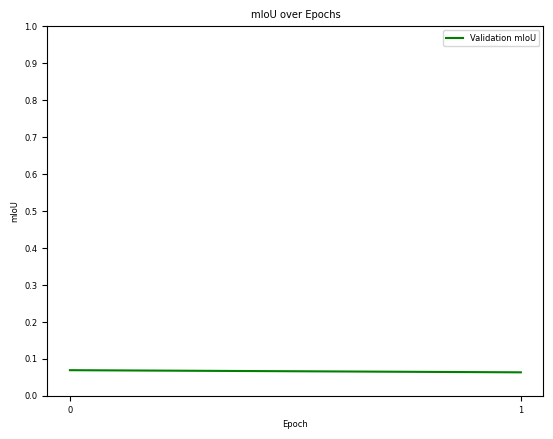

In [ ]:
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y%m%d_%H%M%S")
model_save_path = f'{args["model_save_path"]}/{current_time}_{args["model_folder_suffix"]}'
os.mkdir(model_save_path)

matplotlib.rcParams.update({'font.size': 6})

plt.plot(train_metrics['epoch_train_losses'], label='Train loss', color='blue') 
plt.plot(train_metrics['epoch_val_losses'], label='Validation loss', color='yellow') 
plt.xlabel('Epoch') 
plt.xticks(ticks=np.arange(0, args['epochs']))
plt.ylabel('Loss') 
plt.title('Loss over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/loss_over_epochs.jpg', dpi=1200)

plt.clf()
plt.plot(train_metrics['epoch_val_mious'], label='Validation mIoU', color='green') 
plt.xlabel('Epoch') 
plt.xticks(ticks=np.arange(0, args['epochs']))
plt.ylabel('mIoU') 
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.title('mIoU over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/iou_over_epochs.jpg', dpi=1200)

train_std = train_std.tolist()
train_mean = train_mean.tolist()

eval_args = {'model_load_folder_path': model_save_path,
             'train_std': train_std,
             'train_mean': train_mean,
             'data_source': "real",
             'test_subset_size': 200,
             'test_batch_size': 1,
             'ignore_label': args['ignore_label'],
             'image_width': args['image_width'],
             'image_height': args['image_height']}
eval_args = json.dumps(eval_args, indent=4)
with open(file=f'{model_save_path}/eval-config.json', mode='w') as f:
    f.write(eval_args)
    
args = json.dumps(args, indent=4)
with open(file=f'{model_save_path}/train_config.json', mode='w') as f:
    f.write(args)

train_metrics = json.dumps(train_metrics, indent=4)
with open(file=f'{model_save_path}/train_metrics.json', mode='w') as f:
    f.write(train_metrics)

torch.save(model.state_dict(), f'{model_save_path}/deeplabv3_model.pt')